In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cvxpy as cp
import polytope as pc
import torch
from torch.utils.data import Dataset, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

from evanqp import MPCProblem, Polytope, RandomSampler, FFNN, Verifier
from evanqp.layers import BoundArithmetic
from utils import dlqr

In [3]:
class DoubleIntegrator(MPCProblem):
    def __init__(self, N=10):
        self.N = N

        n = 2
        m = 1

        # Double Integrator
        self.A = np.array([[1, 1], [0, 1]])
        self.B = np.array([[0], [1]])
        
        # Weights
        self.Q = np.diag([1, 1])
        self.R = np.array([[0.1]])
        self.K, self.P, _ = dlqr(self.A, self.B, self.Q, self.R)
        
        # Constraints
        self.x_max = np.array([10.0, 10.0])
        self.x_min = np.array([-10.0, -10.0])
        self.u_max = 1.0
        self.u_min = -1.0
        
        # Terminal Set computation
        # state constraints
        Hx = np.vstack((np.eye(n), -np.eye(n)))
        hx = np.concatenate((self.x_max, -self.x_min))
        # input constraints
        Hu = np.vstack((np.eye(m), -np.eye(m)))
        hu = np.array([self.u_max, -self.u_min])
        # closed loop dynamics
        Ak = self.A - self.B @ self.K
        # state & input constraints
        HH = np.vstack((Hx, -Hu @ self.K))
        hh = np.concatenate((hx, hu))
        # compute maximal invariant set
        O = pc.Polytope(HH, hh)
        while True:
            O_prev = O
            # pre-set
            O = O.intersect(pc.Polytope(O.A @ Ak, O.b))
            if O == O_prev:
                break
        self.F, self.f = O.A, O.b

        self.x0 = cp.Parameter(n, name='x0')
        self.x = cp.Variable((N + 1, n), name='x')
        self.u0 = cp.Variable(m, name='u0')
        self.u = cp.Variable((N, m), name='u')
        
        objective = cp.quad_form(self.x[N, :], self.P)
        constraints = [self.x0 == self.x[0, :], self.u0 == self.u[0, :]]
        for i in range(N):
            objective += cp.quad_form(self.x[i, :], self.Q) + cp.quad_form(self.u[i, :], self.R)
            constraints += [self.x[i + 1, :] == self.A @ self.x[i, :] + self.B @ self.u[i, :]]
            constraints += [self.x_min <= self.x[i, :], self.x[i, :] <= self.x_max]
            constraints += [self.u_min <= self.u[i, :], self.u[i, :] <= self.u_max]
        constraints += [self.F @ self.x[N, :] <= self.f]

        self.objective = cp.Minimize(objective)
        self._problem = cp.Problem(self.objective, constraints)

    def problem(self):
        return self._problem

    def parameters(self):
        return [self.x0]

    def variables(self):
        return [self.u0]

    def solve(self, x0):
        self.x0.value = x0
        self._problem.solve(solver=cp.GUROBI, warm_start=True)

        solution = {self.u0: self.u0.value,
                    self.u: self.u.value,
                    self.x: self.x.value,
                    self.objective: self.objective.value}
        return solution

    def reduced_objective(self):
        objective = cp.quad_form(self.x[self.N, :], self.P)
        for i in range(1, self.N):
            objective += cp.quad_form(self.x[i, :], self.Q) + cp.quad_form(self.u[i, :], self.R)
        return cp.Minimize(objective)

In [4]:
mpc_controller = DoubleIntegrator()

In [5]:
x1 = np.linspace(-10, 10, 250)
x2 = np.linspace(-6, 6, 250)
x, y = np.meshgrid(x1, x2)
z_opt = np.zeros(x.shape)
for i in tqdm(range(x.shape[0])):
    for j in range(x.shape[1]):
        sol = mpc_controller.solve(np.array([x[i, j], y[i, j]]))
        u0 = sol[mpc_controller.variables()[0]]
        z_opt[i, j] = u0 if u0 is not None else None

  0%|          | 0/250 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2022-12-04


/usr/local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1278: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 250/250 [06:19<00:00,  1.52s/it]


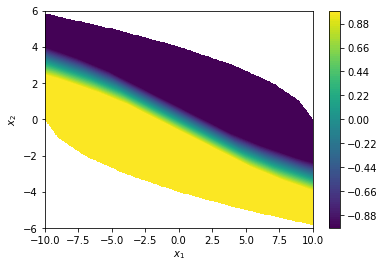

In [6]:
fig, ax = plt.subplots()
cs = ax.contourf(x, y, z_opt, levels=100)
fig.colorbar(cs)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
plt.show()

In [7]:
parameter_set = Polytope(np.array([[1, 0], [-1, 0], [0, 1], [0, -1]]), np.array([10, 10, 10, 10]))

In [9]:
sampler = RandomSampler(mpc_controller, parameter_set)
parameter_samples, variable_samples = sampler.sample(10000, seed=0)

100%|██████████| 10000/10000 [02:30<00:00, 66.34it/s]


In [10]:
parameter_samples = torch.from_numpy(parameter_samples).float()
variable_samples  = torch.from_numpy(variable_samples).float()

torch.save(parameter_samples, 'parameter_samples_qp.pt')
torch.save(variable_samples, 'variable_samples_qp.pt')

In [8]:
parameter_samples = torch.load('parameter_samples_qp.pt')
variable_samples  = torch.load('variable_samples_qp.pt')

In [9]:
class DoubleIntegratorDataset(Dataset):
    def __init__(self, parameter_samples, variable_samples):
        self.parameter_samples = parameter_samples
        self.variable_samples = variable_samples

    def __len__(self):
        return self.parameter_samples.shape[0]

    def __getitem__(self, idx):
        return self.parameter_samples[idx, :], self.variable_samples[idx, :]

In [10]:
dataset = DoubleIntegratorDataset(parameter_samples, variable_samples)

seed = 1
train_set_ratio = 0.8

train_set_size = int(len(dataset) * train_set_ratio)
test_set_size = len(dataset) - train_set_size
train_set, test_set = random_split(dataset, [train_set_size, test_set_size], generator=torch.Generator().manual_seed(seed))

In [13]:
!python3 train.py --train-set-ratio {train_set_ratio} --seed {seed} --parameter-samples-file-name parameter_samples_qp.pt --variable-samples-file-name variable_samples_qp.pt --model-file-name double_integrator_ffnn_qp.pt

Train Epoch: 1 [0/8000 (0%)]	Loss: 0.953956
Train Epoch: 1 [1280/8000 (16%)]	Loss: 0.706792
Train Epoch: 1 [2560/8000 (32%)]	Loss: 0.270024
Train Epoch: 1 [3840/8000 (48%)]	Loss: 0.152905
Train Epoch: 1 [5120/8000 (63%)]	Loss: 0.072452
Train Epoch: 1 [6400/8000 (79%)]	Loss: 0.026421
Train Epoch: 1 [7680/8000 (95%)]	Loss: 0.015031

Test set: Average loss: 0.008460)

Train Epoch: 2 [0/8000 (0%)]	Loss: 0.008736
Train Epoch: 2 [1280/8000 (16%)]	Loss: 0.006925
Train Epoch: 2 [2560/8000 (32%)]	Loss: 0.004418
Train Epoch: 2 [3840/8000 (48%)]	Loss: 0.001819
Train Epoch: 2 [5120/8000 (63%)]	Loss: 0.002377
Train Epoch: 2 [6400/8000 (79%)]	Loss: 0.002205
Train Epoch: 2 [7680/8000 (95%)]	Loss: 0.001396

Test set: Average loss: 0.001106)

Train Epoch: 3 [0/8000 (0%)]	Loss: 0.000774
Train Epoch: 3 [1280/8000 (16%)]	Loss: 0.001677
Train Epoch: 3 [2560/8000 (32%)]	Loss: 0.000886
Train Epoch: 3 [3840/8000 (48%)]	Loss: 0.001049
Train Epoch: 3 [5120/8000 (63%)]	Loss: 0.001239
Train Epoch: 3 [6400/8000 (7

In [11]:
saved_model = torch.load('double_integrator_ffnn_qp.pt')

depth = saved_model['depth']
hidden_size = saved_model['hidden_size']

net = FFNN([hidden_size for _ in range(depth)], input_size=saved_model['input_size'], output_size=saved_model['output_size'])
net.load_state_dict(saved_model['state_dict'])

<All keys matched successfully>

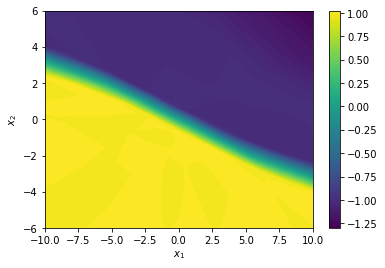

In [12]:
z_net = np.vstack((x.flatten(), y.flatten())).T
z_net = net(torch.from_numpy(z_net).float())
z_net = z_net.detach().cpu().numpy()
z_net = z_net.reshape(x.shape)

fig, ax = plt.subplots()
cs = ax.contourf(x, y, z_net, levels=100)
fig.colorbar(cs)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
plt.show()

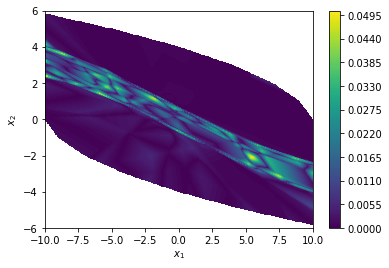

In [13]:
fig, ax = plt.subplots()
cs = ax.contourf(x, y, np.abs(z_opt - z_net), levels=100)
fig.colorbar(cs)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
plt.show()

In [14]:
verifier = Verifier(parameter_set, mpc_controller, net)

In [15]:
mpc_bounds, net_bounds = verifier.compute_bounds(method=BoundArithmetic.INT_ARITHMETIC)
print('Neural Network Bounds:')
print(f'lower bound: {net_bounds["lb"]}')
print(f'upper bound: {net_bounds["ub"]}')

QP Output Bound: 100%|██████████| 1/1 [00:00<00:00, 370.52it/s]

Neural Network Bounds:
lower bound: [-19.54452]
upper bound: [18.35782]


In [16]:
mpc_bounds, net_bounds = verifier.compute_bounds(method=BoundArithmetic.ZONO_ARITHMETIC)
print('Neural Network Bounds:')
print(f'lower bound: {net_bounds["lb"]}')
print(f'upper bound: {net_bounds["ub"]}')

QP Output Bound: 100%|██████████| 1/1 [00:00<00:00, 327.55it/s]

Neural Network Bounds:
lower bound: [-16.74915]
upper bound: [15.27021]


In [17]:
bound, parameters = verifier.find_max_abs_diff()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 631 rows, 484 columns and 2571 nonzeros
Model fingerprint: 0x4e09ff61
Model has 278 general constraints
Variable types: 345 continuous, 139 integer (139 binary)
Coefficient statistics:
  Matrix range     [3e-04, 4e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e-01, 4e+01]
  RHS range        [2e-02, 4e+01]
  GenCon rhs range [6e-01, 1e+01]
  GenCon coe range [4e-01, 1e+00]

User MIP start produced solution with objective 0.00708794 (0.01s)
User MIP start produced solution with objective 0.00753236 (0.01s)
Loaded user MIP start with objective 0.00753236

Presolve removed 184 rows and 174 columns
Presolve time: 0.04s
Presolved: 447 rows, 310 columns, 2521 nonzeros
Presolved model has 36 SOS constraint(s)
Variable types: 199 continuous, 111 integer (111 binary)

Root relaxation: objective 1.219898e+01, 628 iterations, 

In [18]:
print(f'Maximum absolute Error Bound between MPC and NN: {bound} at {parameters}')
u0_mpc = mpc_controller.solve(np.array(parameters))[mpc_controller.u0][0]
u0_net = net(torch.from_numpy(np.array(parameters)).float()).detach().numpy()[0]
print(f'Double Checking by calulcaing error at this position: {u0_mpc - u0_net}')

Maximum absolute Error Bound between MPC and NN: 0.0507661912236348 at [-10.0, 2.4201524493632895]
Double Checking by calulcaing error at this position: 0.05070798146453881


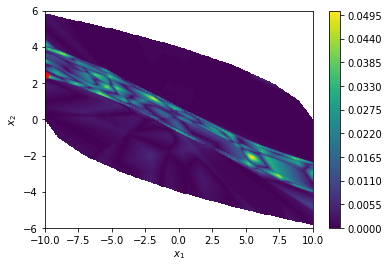

In [19]:
fig, ax = plt.subplots()
cs = ax.contourf(x, y, np.abs(z_opt - z_net), levels=100)
ax.plot(parameters[0], parameters[1], 'ro')
fig.colorbar(cs)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
plt.show()

In [20]:
bound, parameters = verifier.verify_stability()

QP Output Bound: 100%|██████████| 1/1 [00:00<00:00, 326.58it/s]


Set parameter NonConvex to value 2
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 747 rows, 543 columns and 2759 nonzeros
Model fingerprint: 0xc9d185f3
Model has 63 quadratic objective terms
Model has 276 general constraints
Variable types: 404 continuous, 139 integer (139 binary)
Coefficient statistics:
  Matrix range     [3e-04, 4e+01]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-01, 7e+00]
  Bounds range     [2e-01, 4e+01]
  RHS range        [2e-02, 4e+01]
  GenCon rhs range [6e-01, 1e+01]
  GenCon coe range [4e-01, 1e+00]

User MIP start produced solution with objective 307.207 (0.09s)
User MIP start produced solution with objective 283.923 (0.12s)
User MIP start produced solution with objective 49.7919 (0.14s)
User MIP start produced solution with objective 22.4123 (0.15s)
User MIP start produced solution with objective 16.2204 (0.36s)
User MIP start produce

In [21]:
print(f'Stability bound: {bound} at {parameters}, should be >=0 for stability')

Stability bound: 2.9881425435024765e-06 at [0.0002733669995862442, 0.0017642215534419137], should be >=0 for stability
